### Loan Repayment Prediction
This project explores risk analytics in the banking and financial services industry by leveraging machine learning to solve a classification problem. The goal is to predict whether customers will successfully repay their loans or default, using various features related to loan characteristics and the borrower's financial history.

The dataset for this project is sourced from Kaggle, specifically from LendingClub, a leading U.S.-based peer-to-peer lending platform.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

In [2]:
data = pd.read_csv("data.csv")
data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


##### 1. Exploratory Data Analysis

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

Note: Need to handle Null values.

Text(0.5, 0, 'Loan Status')

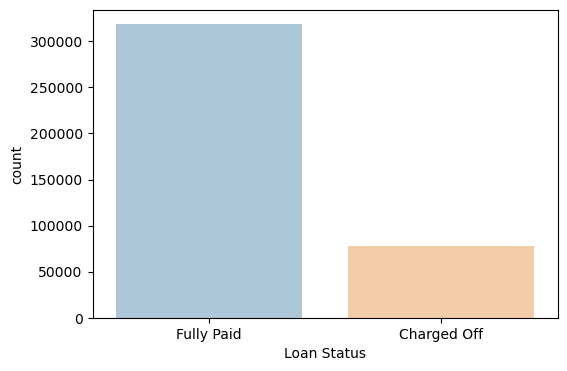

In [4]:
# loan status
plt.figure(figsize=(6, 4))
sns.countplot(x='loan_status', data=data, alpha=0.4)
plt.xlabel('Loan Status')

<Axes: >

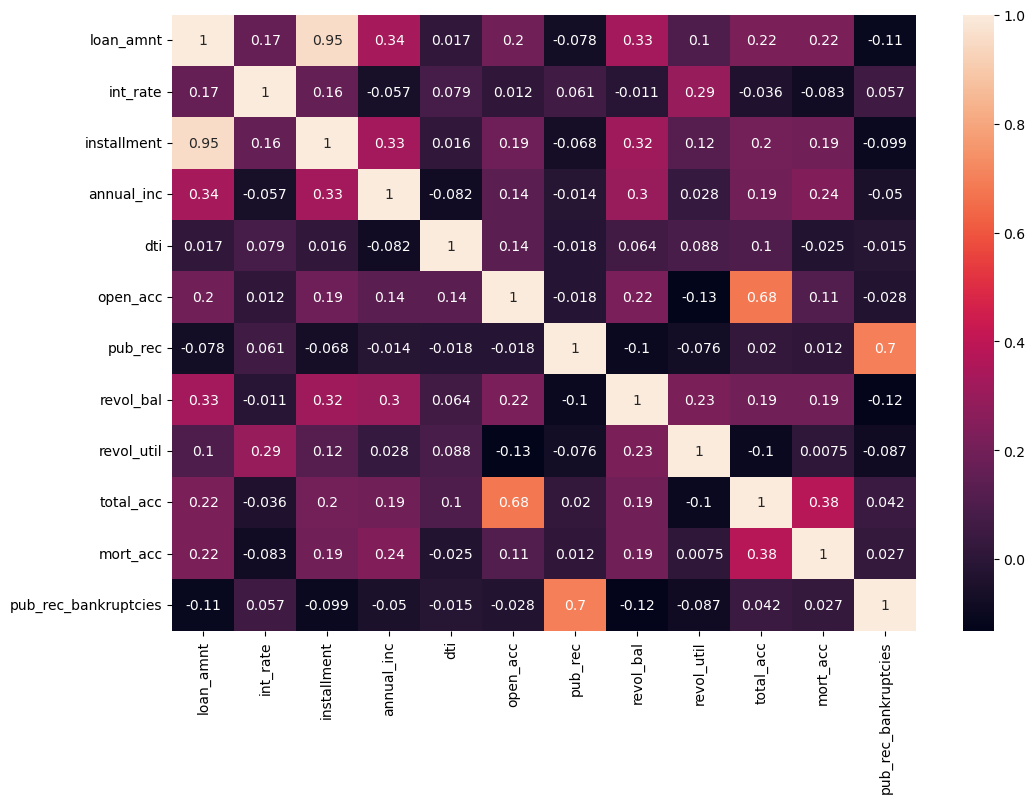

In [5]:
# correlation among variables
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(numeric_only=True), annot=True)

Note: Loan Amount and Installment are strongly positively correlated. Be aware of the potential of duplicate information.

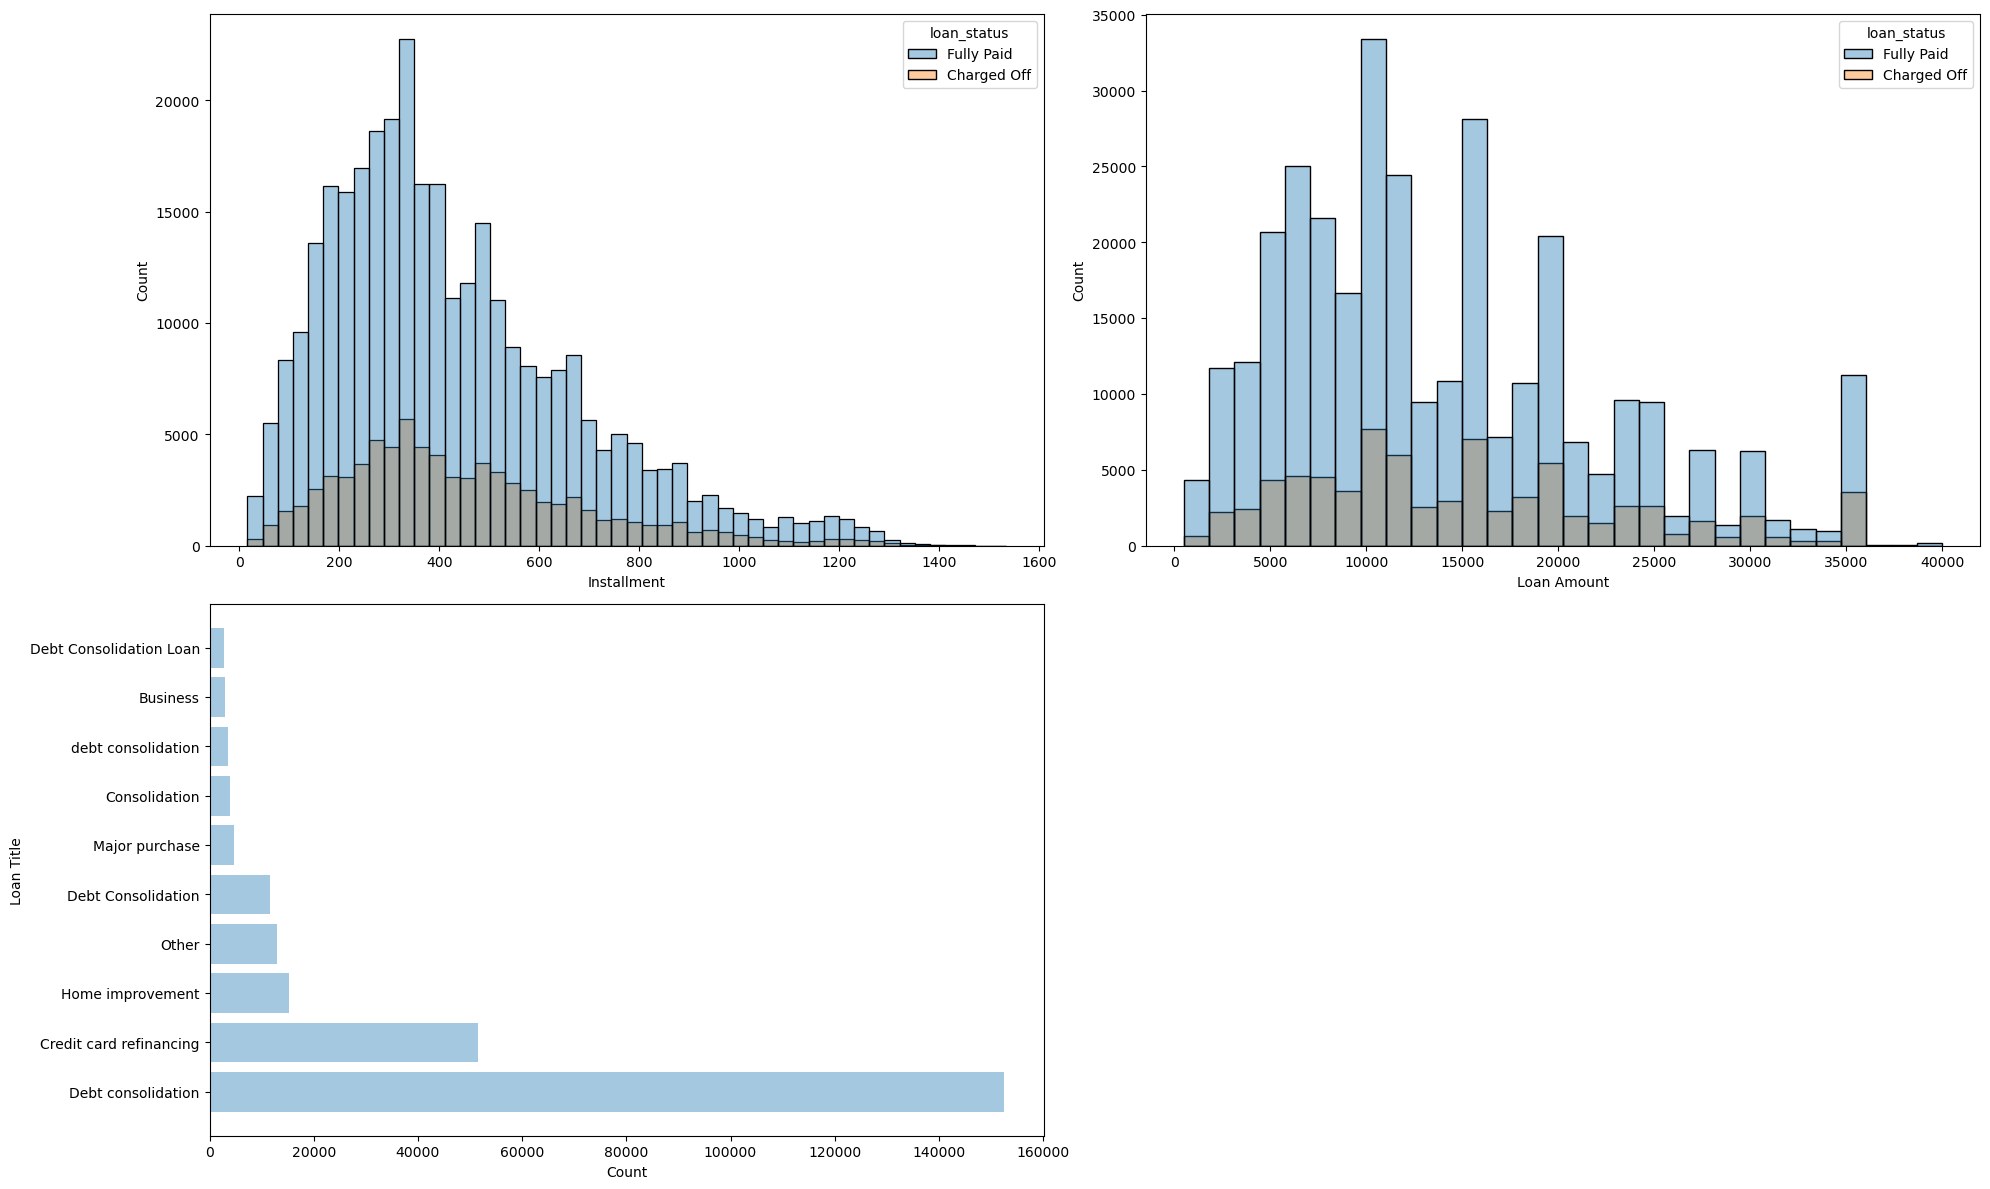

In [6]:
# loan amount, installment & loan title
plt.figure(figsize=(20, 12))  

plt.subplot(2, 2, 1)
sns.histplot(data=data, x='installment', hue='loan_status', bins=50, alpha=0.4)
plt.xlabel('Installment')

plt.subplot(2, 2, 2)
sns.histplot(data=data, x='loan_amnt', hue='loan_status', bins=30, alpha=0.4)
plt.xlabel('Loan Amount')

plt.subplot(2, 2, 3)
plt.barh(data['title'].value_counts()[:10].index, data['title'].value_counts()[:10], alpha=0.4)
plt.xlabel('Count')
plt.ylabel('Loan Title')

plt.tight_layout() 

Note: The distribution of Installments is similar across both loan statuses.

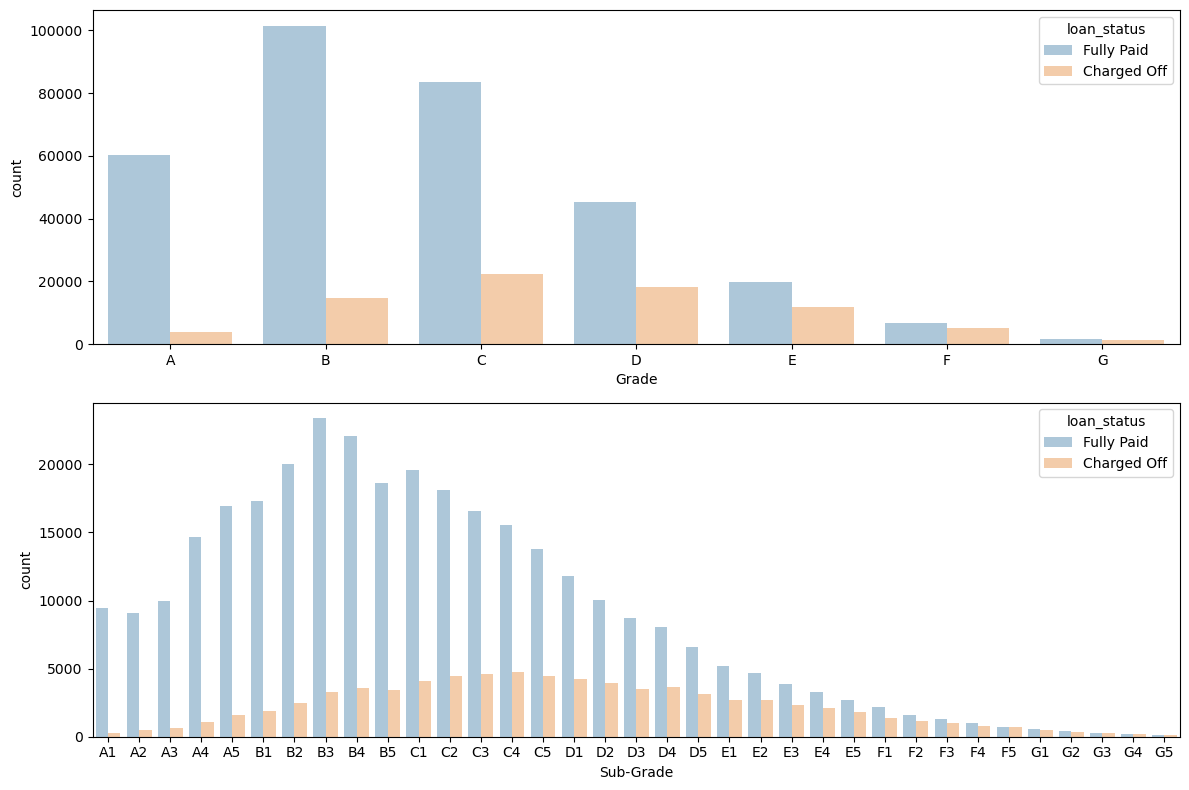

In [7]:
# grades & sub-grades
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
order = ['A','B','C','D','E','F','G']
sns.countplot(data=data, x='grade', hue='loan_status', order=order, alpha=0.4)
plt.xlabel('Grade')

plt.subplot(2, 1, 2)
order = ['A1','A2','A3','A4','A5','B1','B2','B3','B4','B5','C1','C2','C3','C4','C5','D1','D2','D3','D4','D5',
         'E1','E2','E3','E4','E5','F1','F2','F3','F4','F5','G1','G2','G3','G4','G5']
sns.countplot(data=data, x='sub_grade', hue='loan_status', order=order, alpha=0.4)
plt.xlabel('Sub-Grade')

plt.tight_layout() 

Note: Loans in grades E, F, and G have a high default percentage.

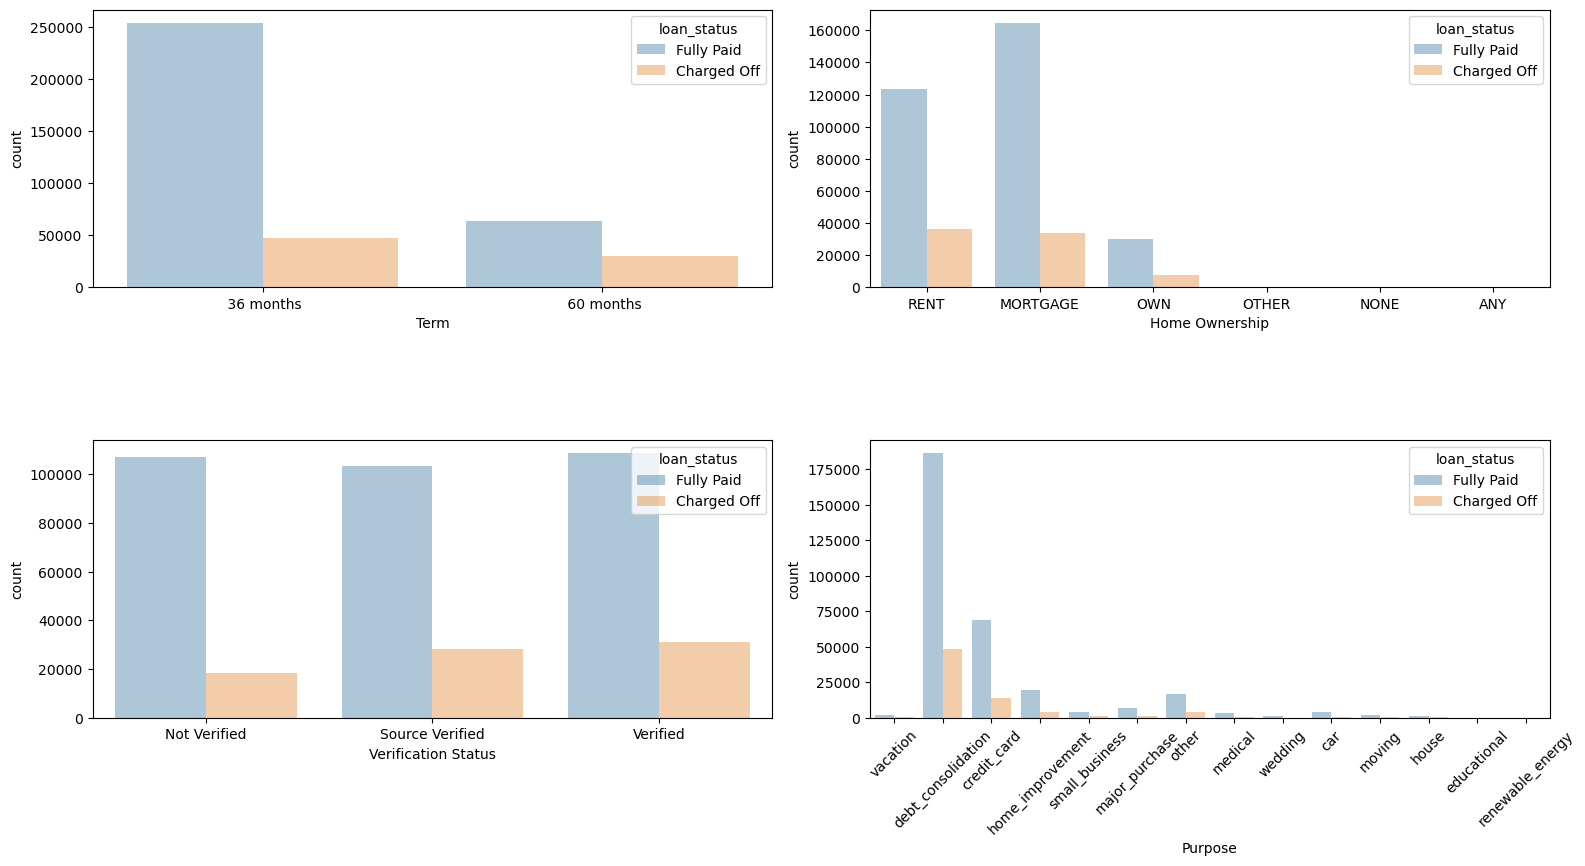

In [8]:
# term, home ownership, verification status & purpose 
plt.figure(figsize=(16, 16))

plt.subplot(4, 2, 1)
sns.countplot(x='term', data=data, hue='loan_status', alpha=0.4)
plt.xlabel('Term')

plt.subplot(4, 2, 2)
sns.countplot(x='home_ownership', data=data, hue='loan_status', alpha=0.4)
plt.xlabel('Home Ownership')

plt.subplot(4, 2, 3)
sns.countplot(x='verification_status', data=data, hue='loan_status', alpha=0.4)
plt.xlabel('Verification Status')

plt.subplot(4, 2, 4)
g = sns.countplot(x='purpose', data=data, hue='loan_status', alpha=0.4)
plt.xlabel('Purpose')
g.set_xticklabels(g.get_xticklabels(), rotation=45)

plt.tight_layout()

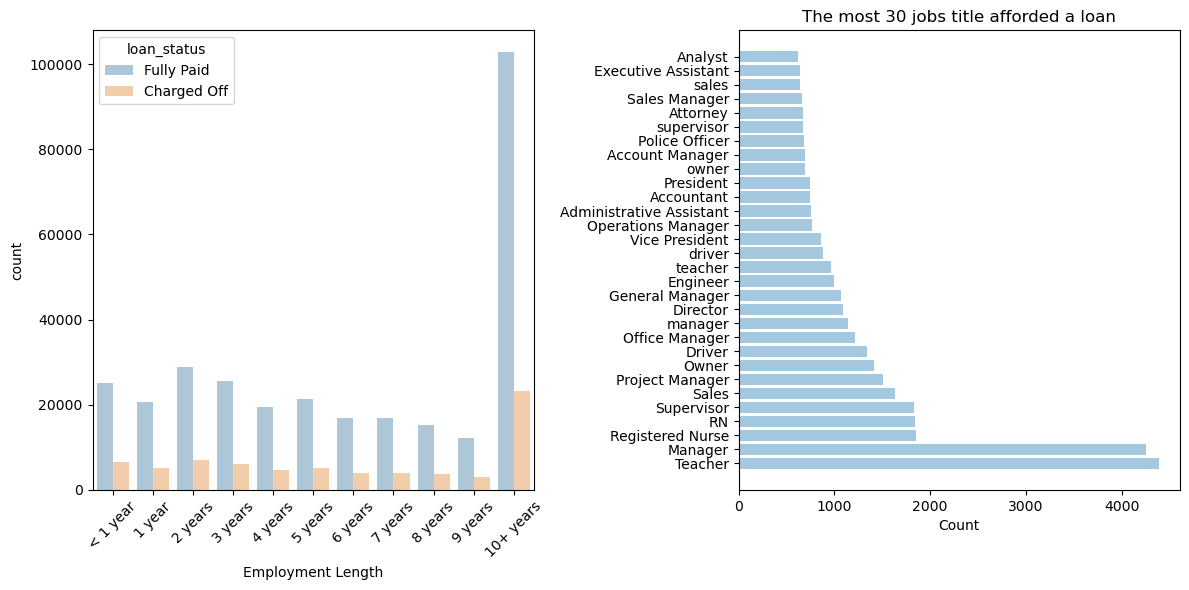

In [9]:
# employment title & employment length
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', 
          '6 years', '7 years', '8 years', '9 years', '10+ years',]
g = sns.countplot(x='emp_length', data=data, hue='loan_status', order=order, alpha=0.4)
plt.xlabel('Employment Length')
g.set_xticklabels(g.get_xticklabels(), rotation=45)

plt.subplot(1, 2, 2)
plt.barh(data['emp_title'].value_counts()[:30].index, data['emp_title'].value_counts()[:30], alpha=0.4)
plt.title('The most 30 jobs title afforded a loan')
plt.xlabel('Count')
plt.tight_layout()

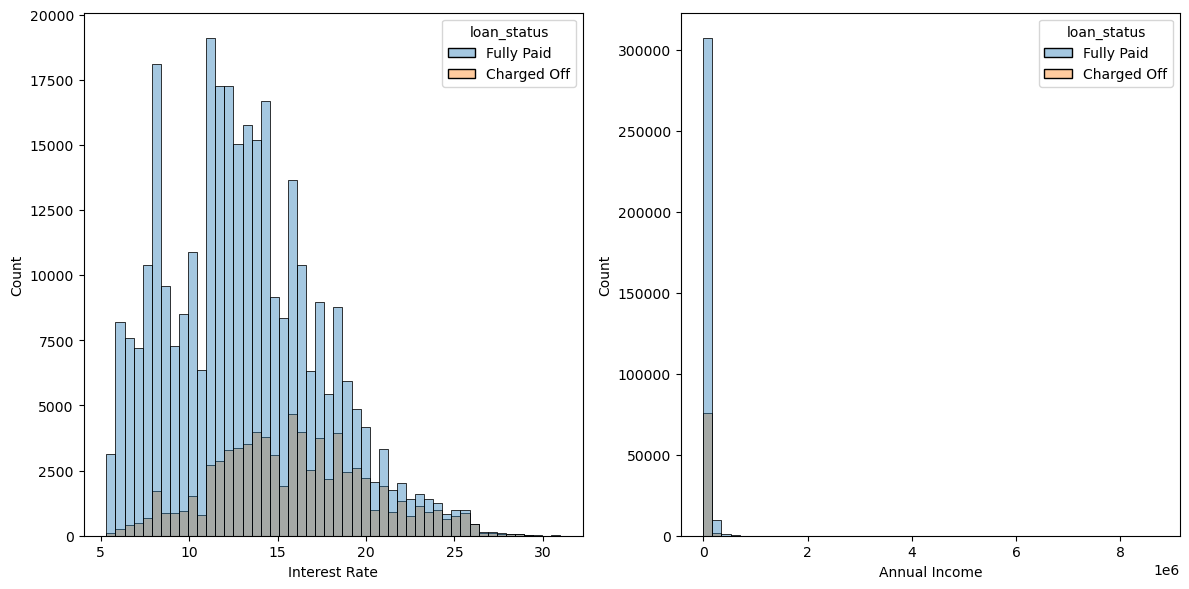

In [10]:
# interest rate & annual income
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=data, x='int_rate', hue='loan_status', bins=50, alpha=0.4)
plt.xlabel('Interest Rate')

plt.subplot(1, 2, 2)
sns.histplot(data=data, x='annual_inc', hue='loan_status', bins=50, alpha=0.4)
plt.xlabel('Annual Income')

plt.tight_layout()

Note:
- Fully Paid loans tend to have lower average interest rates compared to Charged Off (default) loans. 
- Need to handle outliers in 'annual_inc'.

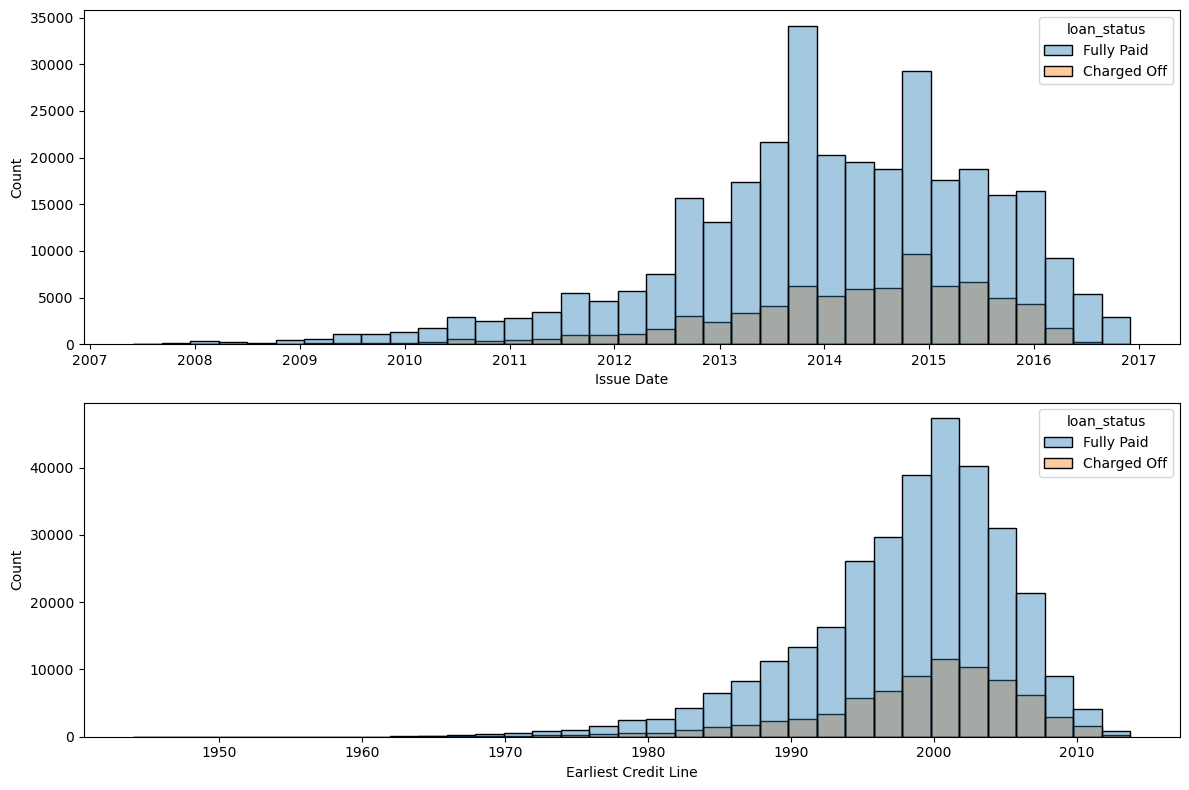

In [11]:
# issue date & earliest credit line
data['issue_d'] = pd.to_datetime(data['issue_d'])
data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'])
plt.figure(figsize=(12, 8))  

plt.subplot(2, 1, 1)
sns.histplot(data=data, x='issue_d', hue='loan_status', bins=35, alpha=0.4)
plt.xlabel('Issue Date')

plt.subplot(2, 1, 2)
sns.histplot(data=data, x='earliest_cr_line', hue='loan_status', bins=35, alpha=0.4)
plt.xlabel('Earliest Credit Line')

plt.tight_layout()  

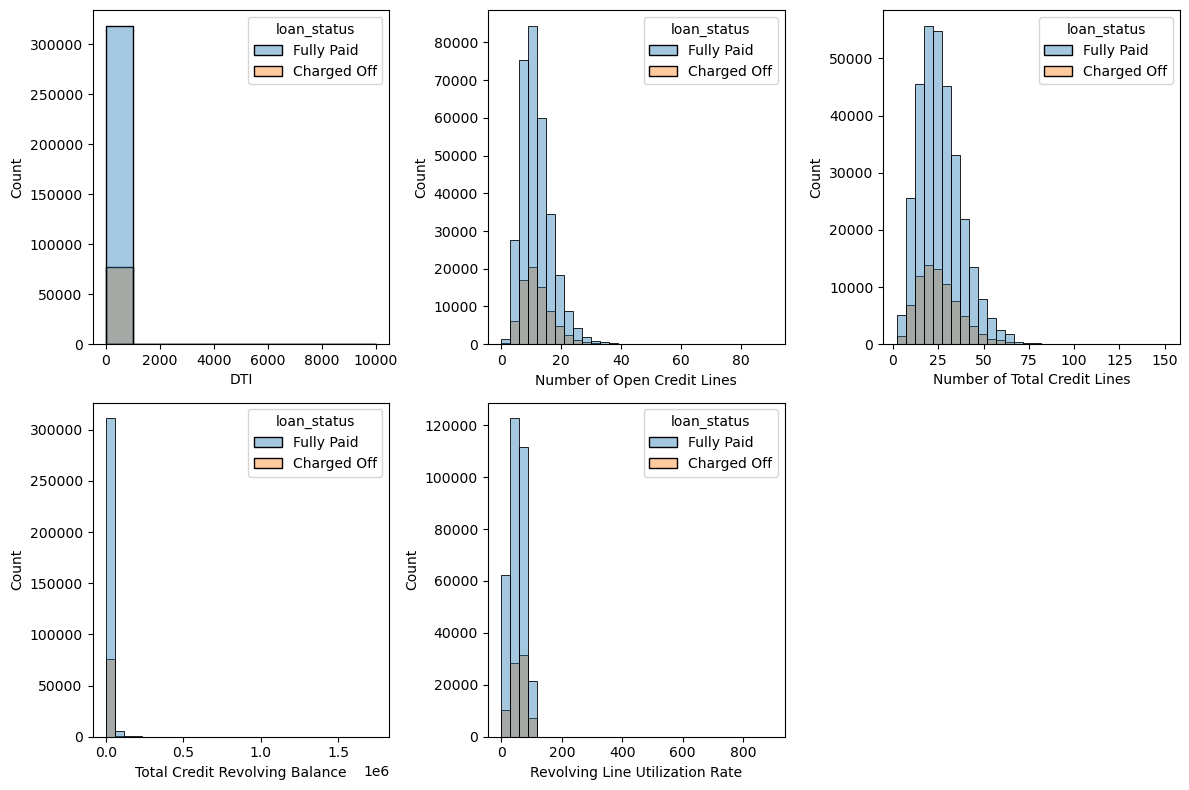

In [12]:
# dti, #of open credit lines, #of total credit lines, total credit revolving balance, revolving line utilization rate
plt.figure(figsize=(12, 8))  

plt.subplot(2, 3, 1)
sns.histplot(data=data, x='dti', hue='loan_status', bins=10, alpha=0.4)
plt.xlabel('DTI')

plt.subplot(2, 3, 2)
sns.histplot(data=data, x='open_acc', hue='loan_status', bins=30, alpha=0.4)
plt.xlabel('Number of Open Credit Lines')

plt.subplot(2, 3, 3)
sns.histplot(data=data, x='total_acc', hue='loan_status', bins=30, alpha=0.4)
plt.xlabel('Number of Total Credit Lines')

plt.subplot(2, 3, 4)
sns.histplot(data=data, x='revol_bal', hue='loan_status', bins=30, alpha=0.4)
plt.xlabel('Total Credit Revolving Balance')

plt.subplot(2, 3, 5)
sns.histplot(data=data, x='revol_util', hue='loan_status', bins=30, alpha=0.4)
plt.xlabel('Revolving Line Utilization Rate')

plt.tight_layout()  

Note: Need to handle outliers in 'dti', 'open_acc', total_acc', 'revol_bal', 'revol_util'.

In [13]:
def pub_rec(number):
    if number == 0.0:
        return 0
    else:
        return 1
    
def mort_acc(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number
    
def pub_rec_bankruptcies(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number

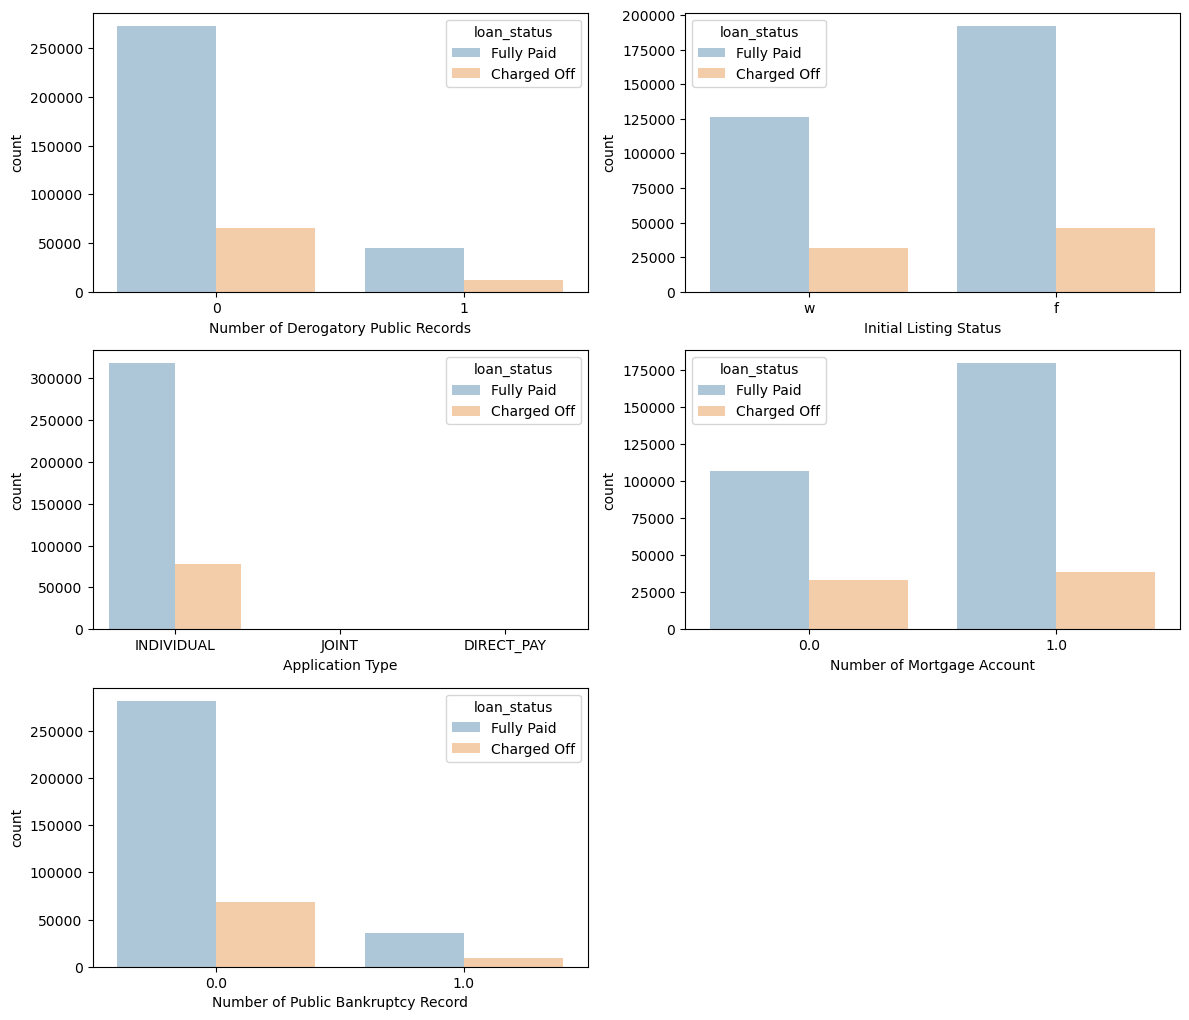

In [14]:
# #of derogatory public records, initial listing status, application type, #of mortgage account, #of public bankruptcy record
plt.figure(figsize=(12, 20))

plt.subplot(6, 2, 1)
data['pub_rec'] = data['pub_rec'].apply(pub_rec)
sns.countplot(x='pub_rec', data=data, hue='loan_status', alpha=0.4)
plt.xlabel('Number of Derogatory Public Records')

plt.subplot(6, 2, 2)
sns.countplot(x='initial_list_status', data=data, hue='loan_status', alpha=0.4)
plt.xlabel('Initial Listing Status')

plt.subplot(6, 2, 3)
sns.countplot(x='application_type', data=data, hue='loan_status', alpha=0.4)
plt.xlabel('Application Type')

plt.subplot(6, 2, 4)
data['mort_acc'] = data['mort_acc'].apply(mort_acc)
sns.countplot(x='mort_acc', data=data, hue='loan_status', alpha=0.4)
plt.xlabel('Number of Mortgage Account')

plt.subplot(6, 2, 5)
data['pub_rec_bankruptcies'] = data['pub_rec_bankruptcies'].apply(pub_rec_bankruptcies)
sns.countplot(x='pub_rec_bankruptcies', data=data, hue='loan_status', alpha=0.4)
plt.xlabel('Number of Public Bankruptcy Record')

plt.tight_layout()  

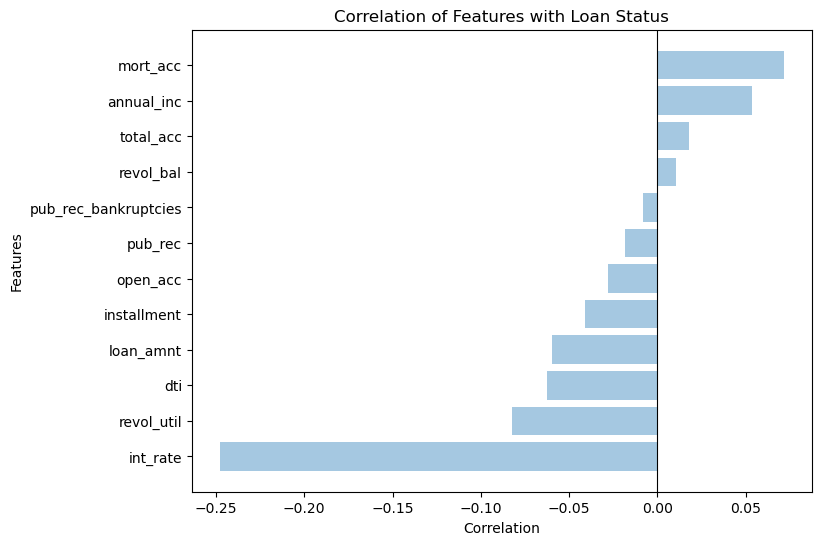

In [15]:
# Correlation among other features and loan status 
data['loan_status'] = data.loan_status.map({'Fully Paid':1, 'Charged Off':0})

corr_values = data.corr(numeric_only=True)['loan_status'].drop('loan_status').sort_values()

plt.figure(figsize=(8, 6))
plt.barh(corr_values.index, corr_values.values, alpha=0.4)
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.title('Correlation of Features with Loan Status')
plt.axvline(0, color='black', linewidth=0.8)

Note: Interest Rate, Number of Mortgage Accounts, and Revolving Line Utilization Rate show relatively strong correlations with Loan Status.

##### 2. Data Processing

In [16]:
# missing values
for column in data.columns:
    if data[column].isna().sum() != 0:
        missing = data[column].isna().sum()
        portion = (missing / data.shape[0]) * 100
        print(f"'{column}': missing values {portion:.3f}%")

'emp_title': missing values 5.789%
'emp_length': missing values 4.621%
'title': missing values 0.443%
'revol_util': missing values 0.070%
'mort_acc': missing values 9.543%
'pub_rec_bankruptcies': missing values 0.135%


In [17]:
data['emp_title'].nunique()

173105

Note: Too many unique job titles. Not informative to convert this to a dummy variable feature. Remove 'emp_title' column.

In [18]:
for year in data['emp_length'].unique():
    print(f'Loan status by {year} years of employment:')
    print(f'{data[data.emp_length == year].loan_status.value_counts(normalize=True)}')
    print('==========================================')

Loan status by 10+ years years of employment:
1    0.815814
0    0.184186
Name: loan_status, dtype: float64
Loan status by 4 years years of employment:
1    0.807615
0    0.192385
Name: loan_status, dtype: float64
Loan status by < 1 year years of employment:
1    0.793128
0    0.206872
Name: loan_status, dtype: float64
Loan status by 6 years years of employment:
1    0.810806
0    0.189194
Name: loan_status, dtype: float64
Loan status by 9 years years of employment:
1    0.79953
0    0.20047
Name: loan_status, dtype: float64
Loan status by 2 years years of employment:
1    0.806738
0    0.193262
Name: loan_status, dtype: float64
Loan status by 3 years years of employment:
1    0.804769
0    0.195231
Name: loan_status, dtype: float64
Loan status by 8 years years of employment:
1    0.80024
0    0.19976
Name: loan_status, dtype: float64
Loan status by 7 years years of employment:
1    0.805226
0    0.194774
Name: loan_status, dtype: float64
Loan status by 5 years years of employment:
1  

Note: Distribtution between Fully Paid and Charge off are extremely similar across all employment lengths. Remove 'emp_length' column.

<BarContainer object of 12 artists>

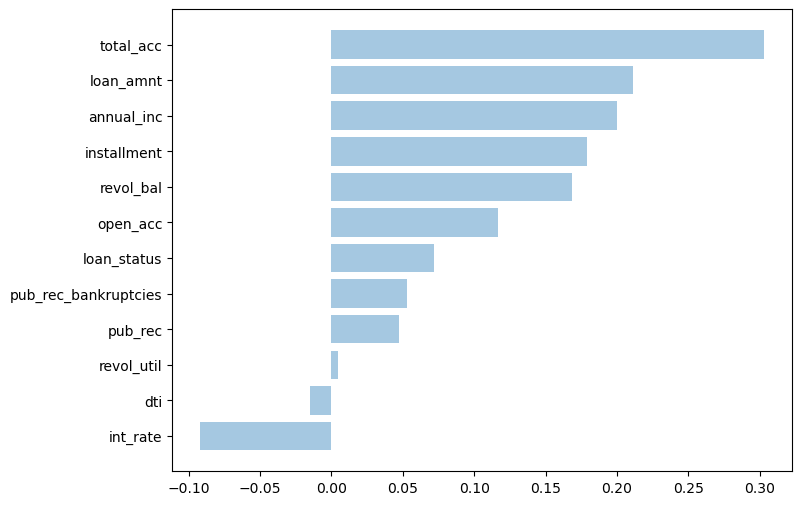

In [19]:
# Correlation among other features and #of mortgage account
corr_values = data.corr(numeric_only=True)['mort_acc'].drop('mort_acc').sort_values()  
plt.figure(figsize=(8, 6))
plt.barh(corr_values.index, corr_values.values, alpha=0.4)

Note: 'total_acc' correlates with 'mort_acc'. Fill missing values in 'mort_acc' by grouping data by 'total_acc' and calculating the mean value for 'mort_acc' per 'total_acc'.

In [20]:
total_acc_avg = data.groupby('total_acc')['mort_acc'].mean()
data['mort_acc'] = data['mort_acc'].fillna(data['total_acc'].map(total_acc_avg).round())

Note:
- 'title' column is a description of 'purpose' column. Remove 'title' column. 
- The missing data points in 'revol_util' and 'pub_rec_bankruptcies' columns account for less than 0.5% of the total data. Remove the rows in 'revol_util' and 'pub_rec_bankruptcies' with missing values. 
- 'grade' column is similar to 'sub_grade' column, but more general. Remove 'grade' column.
- 'issue_d' column would cause data leakage. Remove 'issue_d' column.

In [21]:
data.drop(['emp_title','emp_length','title','grade','issue_d','earliest_cr_line'], axis=1, inplace=True)
data.dropna(inplace=True)

In [22]:
# convert categorical variables
term_values = {' 36 months': 36, ' 60 months': 60}
data['term'] = data['term'].map(term_values)

dummies = ['sub_grade', 'verification_status', 'purpose', 'initial_list_status', 
           'application_type', 'home_ownership']
data = pd.get_dummies(data, columns=dummies, drop_first=True)

In [23]:
data['zip_code'] = data['address'].apply(lambda x: x[-5:])
data = pd.get_dummies(data, columns=['zip_code'], drop_first=True)
data.drop('address', axis=1, inplace=True)

In [24]:
# remove duplicates
data.drop_duplicates(inplace=True)

In [25]:
# train test split
train, test = train_test_split(data, test_size=0.25, random_state=42)

In [26]:
# remove outliers
train = train[train['annual_inc'] <= 250000]
train = train[train['dti'] <= 50]
train = train[train['open_acc'] <= 40]
train = train[train['total_acc'] <= 80]
train = train[train['revol_util'] <= 120]
train = train[train['revol_bal'] <= 250000]

In [27]:
# normalize data
X_train, y_train = train.drop('loan_status', axis=1), train.loan_status
X_test, y_test = test.drop('loan_status', axis=1), test.loan_status

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [28]:
# transform data type 
X_train = np.array(X_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

##### 3.Modeling

In [29]:
def evaluate(actual, pred, train=True):
    phase = "Train" if train else "Test"
    
    # Generate classification report as a DataFrame
    clf_report = pd.DataFrame(classification_report(actual, pred, output_dict=True))
    
    print(f"{phase} Result:\n" + "="*50)
    print(f"Accuracy Score: {accuracy_score(actual, pred) * 100:.2f}%")
    print("-" * 50)
    print("CLASSIFICATION REPORT:\n", clf_report)
    print("-" * 50)
    print("Confusion Matrix:\n", confusion_matrix(actual, pred), "\n")

##### Random Forest Classifier

In [30]:
# define hyperparameters
params = {
    'n_estimators': 100,       
    'max_depth': 10,              
    'min_samples_split': 10, 
    'min_samples_leaf': 5 
}

# build model
rf_clf = RandomForestClassifier(**params)
# train model
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=10)

In [31]:
# evaluate training set performance
y_train_pred = rf_clf.predict(X_train)
evaluate(y_train, y_train_pred.round(), train=True)

Train Result:
Accuracy Score: 88.75%
--------------------------------------------------
CLASSIFICATION REPORT:
                     0.0            1.0  accuracy      macro avg   weighted avg
precision      1.000000       0.877125  0.887496       0.938563       0.901320
recall         0.428638       1.000000  0.887496       0.714319       0.887496
f1-score       0.600065       0.934541  0.887496       0.767303       0.868681
support    57783.000000  235673.000000  0.887496  293456.000000  293456.000000
--------------------------------------------------
Confusion Matrix:
 [[ 24768  33015]
 [     0 235673]] 



In [32]:
# evaluate testing set performance
y_test_pred = rf_clf.predict(X_test)
evaluate(y_test, y_test_pred.round(), train=True)

Train Result:
Accuracy Score: 88.88%
--------------------------------------------------
CLASSIFICATION REPORT:
                     0.0           1.0  accuracy     macro avg  weighted avg
precision      1.000000      0.878615  0.888842      0.939308      0.902335
recall         0.431139      1.000000  0.888842      0.715569      0.888842
f1-score       0.602512      0.935386  0.888842      0.768949      0.870341
support    19307.000000  79498.000000  0.888842  98805.000000  98805.000000
--------------------------------------------------
Confusion Matrix:
 [[ 8324 10983]
 [    0 79498]] 



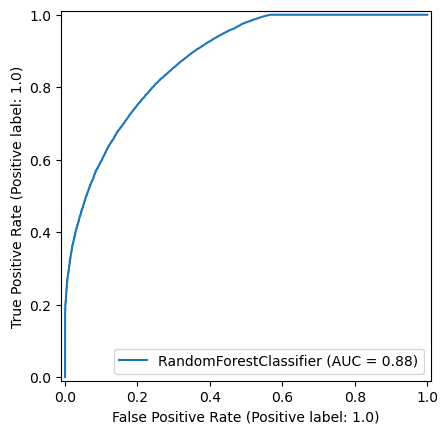

In [33]:
# roc curve
RocCurveDisplay.from_estimator(rf_clf, X_test, y_test)

##### XGBoost Classifier

In [34]:
# define hyperparameters
params = {
    'n_estimators': 100,       
    'max_depth': 6,              
    'learning_rate': 0.1, 
    'subsample': 0.8, 
    'colsample_bytree': 0.8
}

# build model
xgb_clf = XGBClassifier(**params)
# train model
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [35]:
# evaluate training set performance
y_train_pred = xgb_clf.predict(X_train)
evaluate(y_train, y_train_pred.round(), train=True)

Train Result:
Accuracy Score: 88.97%
--------------------------------------------------
CLASSIFICATION REPORT:
                     0.0            1.0  accuracy      macro avg   weighted avg
precision      0.963586       0.882074  0.889687       0.922830       0.898124
recall         0.457038       0.995765  0.889687       0.726401       0.889687
f1-score       0.620002       0.935478  0.889687       0.777740       0.873359
support    57783.000000  235673.000000  0.889687  293456.000000  293456.000000
--------------------------------------------------
Confusion Matrix:
 [[ 26409  31374]
 [   998 234675]] 



In [36]:
# evaluate testing set performance
y_test_pred = xgb_clf.predict(X_test)
evaluate(y_test, y_test_pred.round(), train=True)

Train Result:
Accuracy Score: 89.00%
--------------------------------------------------
CLASSIFICATION REPORT:
                     0.0           1.0  accuracy     macro avg  weighted avg
precision      0.957786      0.883011  0.889985      0.920399      0.897623
recall         0.457140      0.995107  0.889985      0.726123      0.889985
f1-score       0.618891      0.935714  0.889985      0.777302      0.873805
support    19307.000000  79498.000000  0.889985  98805.000000  98805.000000
--------------------------------------------------
Confusion Matrix:
 [[ 8826 10481]
 [  389 79109]] 



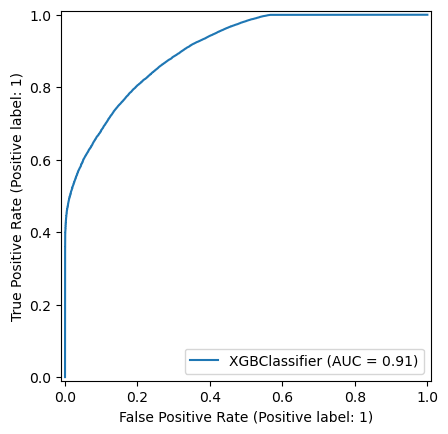

In [37]:
# roc curve
RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test)

##### Artificial Neural Networks (ANNs)

In [38]:
def build_nn_model(input_dim, output_dim, hidden_units, dropout_rates, learning_rate):

    assert len(dropout_rates) == len(hidden_units) + 1

    # input layer
    inputs = Input(shape=(input_dim,))
    x = BatchNormalization()(inputs)
    x = Dropout(dropout_rates[0])(x)

    # hidden layers
    for units, dropout in zip(hidden_units, dropout_rates[1:]):
        x = Dense(units, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout)(x)

    # output layer
    outputs = Dense(output_dim, activation="sigmoid")(x)

    # compile model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=[AUC(name="AUC")]
    )

    return model


def plot_learning_evolution(r):
    plt.figure(figsize=(12, 6))

    # loss plot
    plt.subplot(1, 2, 1)
    plt.plot(r.history['loss'], label='Train Loss')
    plt.plot(r.history['val_loss'], label='Validation Loss')
    plt.title('Loss Evolution During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # AUC plot
    plt.subplot(1, 2, 2)
    plt.plot(r.history['AUC'], label='Train AUC')
    plt.plot(r.history['val_AUC'], label='Validation AUC')
    plt.title('AUC Score Evolution During Training')
    plt.xlabel('Epochs')
    plt.ylabel('AUC Score')
    plt.legend()

    plt.tight_layout()

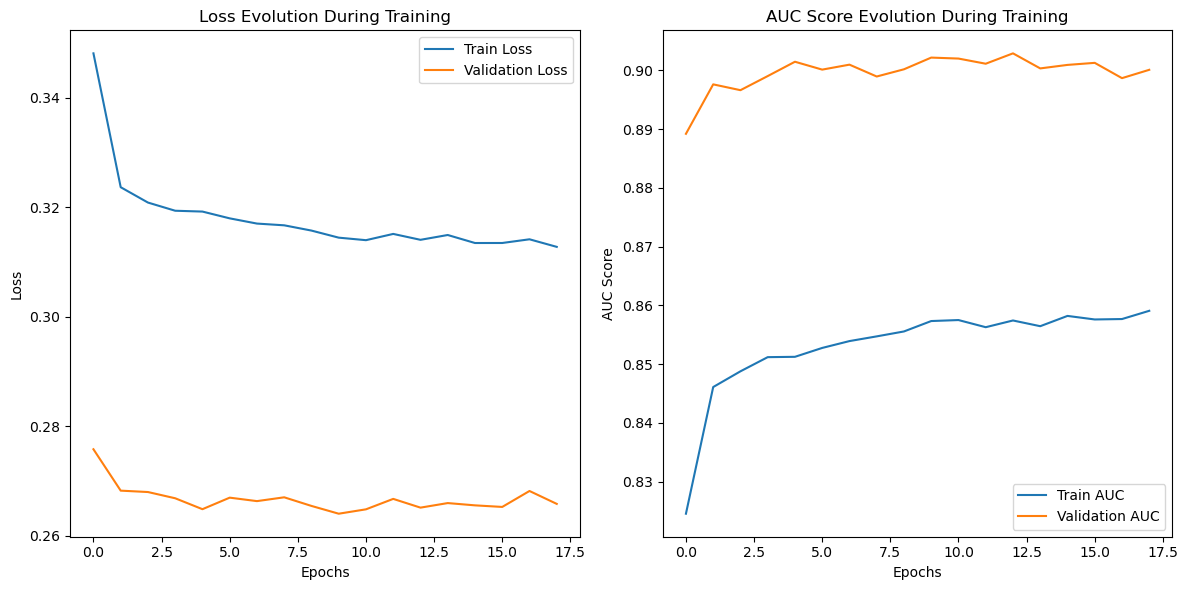

In [39]:
# define hyperparameters
num_features = X_train.shape[1]
output_dim = 1
hidden_layers = [64, 32]
dropout_values = [0.2, 0.3, 0.4]
learning_rate = 1e-3

early_stopping = EarlyStopping(
    monitor="val_AUC",
    patience=5,
    mode="max",
    restore_best_weights=True
)

# build model
model = build_nn_model(
    input_dim=num_features,
    output_dim=output_dim,
    hidden_units=hidden_layers,
    dropout_rates=dropout_values,
    learning_rate=learning_rate
)

# train model
r = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=0
)

# evaluate model
plot_learning_evolution(r)

In [40]:
# evaluate training set performance 
y_train_pred = model.predict(X_train)
evaluate(y_train, y_train_pred.round(), train=True)

9171/9171 ━━━━━━━━━━━━━━━━━━━━ 9s 952us/step
Train Result:
Accuracy Score: 88.76%
--------------------------------------------------
CLASSIFICATION REPORT:
                     0.0            1.0  accuracy      macro avg   weighted avg
precision      0.994258       0.877605  0.887574       0.935932       0.900575
recall         0.431528       0.999389  0.887574       0.715459       0.887574
f1-score       0.601844       0.934546  0.887574       0.768195       0.869035
support    57783.000000  235673.000000  0.887574  293456.000000  293456.000000
--------------------------------------------------
Confusion Matrix:
 [[ 24935  32848]
 [   144 235529]] 



In [41]:
# evaluate testing set performance
y_test_pred = model.predict(X_test)
evaluate(y_test, y_test_pred.round(), train=False)

3088/3088 ━━━━━━━━━━━━━━━━━━━━ 2s 770us/step
Test Result:
Accuracy Score: 88.88%
--------------------------------------------------
CLASSIFICATION REPORT:
                     0.0           1.0  accuracy     macro avg  weighted avg
precision      0.993121      0.879024  0.888761      0.936073      0.901319
recall         0.433729      0.999270  0.888761      0.716500      0.888761
f1-score       0.603771      0.935298  0.888761      0.769534      0.870516
support    19307.000000  79498.000000  0.888761  98805.000000  98805.000000
--------------------------------------------------
Confusion Matrix:
 [[ 8374 10933]
 [   58 79440]] 



##### 4. Comparing models

9171/9171 ━━━━━━━━━━━━━━━━━━━━ 7s 709us/step
3088/3088 ━━━━━━━━━━━━━━━━━━━━ 2s 755us/step


Text(0, 0.5, 'Model')

<Figure size 1000x600 with 0 Axes>

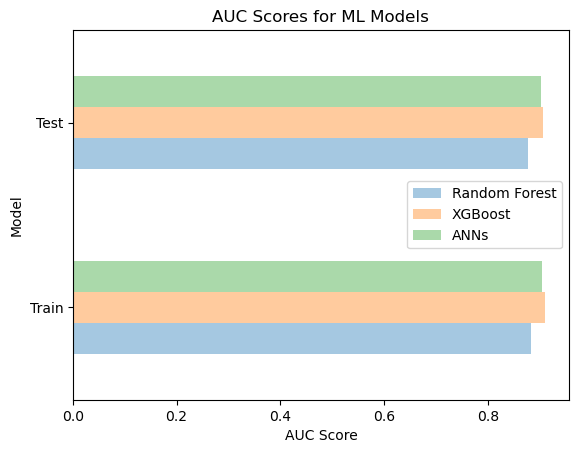

In [42]:
# AUC scores
scores_dict = {
    'Random Forest': {
        'Train': roc_auc_score(y_train, rf_clf.predict_proba(X_train)[:, 1]),
        'Test': roc_auc_score(y_test, rf_clf.predict_proba(X_test)[:, 1]),
    },
    'XGBoost': {
        'Train': roc_auc_score(y_train, xgb_clf.predict_proba(X_train)[:, 1]),
        'Test': roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1]),
    },
    'ANNs': {
        'Train': roc_auc_score(y_train, model.predict(X_train)[:, 0]),
        'Test': roc_auc_score(y_test, model.predict(X_test)[:, 0]),
    },
}

scores_df = pd.DataFrame(scores_dict)

plt.figure(figsize=(10, 6))
scores_df.plot(kind='barh', alpha=0.4, legend=True)
plt.title('AUC Scores for ML Models')
plt.xlabel('AUC Score')
plt.ylabel('Model')


In [43]:
scores_df

,Random Forest,XGBoost,ANNs
Train,0.882328,0.910599,0.903564
Test,0.878163,0.905404,0.903007
